# Modelo Preditiva para Detecção de Fraude

## Introdução
Este projeto tem como objetivo criar um modelo preditivo para detectar fraudes. Os dados necessários para o desenvolvimento do modelo estão disponíveis no site da do [Kaggle](https://www.kaggle.com/datasets/gopalmahadevan/fraud-detection-example).

## Objetivo
Este projeto busca criar um modelo preditivo que classifique a probabilidade de fraude, com base em dados históricos coletados. O objetivo é fornecer uma previsão precisa e útil para avaliação de riscos financeiros.

## Dicionário dos dados

<ul>
        <li><strong>step:</strong> unidade de tempo (1 hora)</li>
        <li><strong>type:</strong> CASH-IN, CASH-OUT, DEBIT, PAYMENT e TRANSFER.</li>
        <li><strong>amount:</strong> valor da transação na moeda local.</li>
        <li><strong>nameOrig:</strong> originador da transação</li>
        <li><strong>oldbalanceOrg:</strong> saldo inicial (antes da transação)</li>
        <li><strong>newbalanceOrig:</strong> novo saldo (após a transação)</li>
        <li><strong>nameDest:</strong> destinatário da transação</li>
        <li><strong>oldbalanceDest:</strong> saldo inicial antes da transação.</li>
        <li><strong>newbalanceDest:</strong> novo saldo após a transação.</li>
        <li><strong>isFraud:</strong> Agente fraudulento assume o controle das contas dos clientes e tenta esvaziá-las transferindo para outra conta e depois sacando.</li>
        <li><strong>isFlaggedFraud:</strong> Tentativa ilegal de transferir uma quantia massiva de dinheiro em uma única transação.</li>
</ul>



## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE


## Carregando os dados

In [2]:
dados = pd.read_csv('Dados/fraud_dataset_example.csv')
dados.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

### Ordenando as colunas do dataframe

In [3]:
dados = dados[['isFraud',
       'isFlaggedFraud','step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest']]

dados.head()

isFraud  isFlaggedFraud  step      type    amount     nameOrig  \
0        0               0     1   PAYMENT   9839.64  C1231006815   
1        0               0     1   PAYMENT   1864.28  C1666544295   
2        1               0     1  TRANSFER    181.00  C1305486145   
3        1               0     1  CASH_OUT    181.00   C840083671   
4        0               0     1   PAYMENT  11668.14  C2048537720   

   oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  
0       170136.0       160296.36  M1979787155             0.0             0.0  
1        21249.0        19384.72  M2044282225             0.0             0.0  
2          181.0            0.00   C553264065             0.0             0.0  
3          181.0            0.00    C38997010         21182.0             0.0  
4        41554.0        29885.86  M1230701703             0.0             0.0

### Renomeando as colunas

In [4]:
colunas = {
    'isFraud': 'fraude',
    'isFlaggedFraud':'super_fraude',
    'step':'tempo',
    'type':'tipo',
    'amount':'valor',
    'nameOrig':'cliente1',
    'oldbalanceOrg':'saldo_inicial_c1',
    'newbalanceOrig':'novo_saldo_c1',
    'nameDest':'cliente2',
    'oldbalanceDest':'saldo_inicial_c2',
    'newbalanceDest':'novo_saldo_c2',
}

dados.rename(columns=colunas, inplace=True)

dados.head()

fraude  super_fraude  tempo      tipo     valor     cliente1  \
0       0             0      1   PAYMENT   9839.64  C1231006815   
1       0             0      1   PAYMENT   1864.28  C1666544295   
2       1             0      1  TRANSFER    181.00  C1305486145   
3       1             0      1  CASH_OUT    181.00   C840083671   
4       0             0      1   PAYMENT  11668.14  C2048537720   

   saldo_inicial_c1  novo_saldo_c1     cliente2  saldo_inicial_c2  \
0          170136.0      160296.36  M1979787155               0.0   
1           21249.0       19384.72  M2044282225               0.0   
2             181.0           0.00   C553264065               0.0   
3             181.0           0.00    C38997010           21182.0   
4           41554.0       29885.86  M1230701703               0.0   

   novo_saldo_c2  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0

## Análise exploratória

In [5]:
print(f'Número de linhas: {dados.shape[0]}\nNúmero de colunas: {dados.shape[1]}')

Número de linhas: 101613
Número de colunas: 11


In [6]:
dados.describe().T

count          mean           std   min       25%  \
fraude            101613.0  1.141586e-03  3.376824e-02  0.00      0.00   
super_fraude      101613.0  0.000000e+00  0.000000e+00  0.00      0.00   
tempo             101613.0  8.523457e+00  1.820681e+00  1.00      8.00   
valor             101613.0  1.740901e+05  3.450199e+05  0.32  10016.59   
saldo_inicial_c1  101613.0  9.071753e+05  2.829575e+06  0.00      0.00   
novo_saldo_c1     101613.0  9.234992e+05  2.867319e+06  0.00      0.00   
saldo_inicial_c2  101613.0  8.810428e+05  2.399949e+06  0.00      0.00   
novo_saldo_c2     101613.0  1.183998e+06  2.797761e+06  0.00      0.00   

                       50%         75%          max  
fraude                0.00        0.00         1.00  
super_fraude          0.00        0.00         0.00  
tempo                 9.00       10.00        10.00  
valor             53385.41   212498.40  10000000.00  
saldo_inicial_c1  20190.47   194715.00  38939424.03  
novo_saldo_c1         0.00   219217.76  38946233.02  
saldo_inicial_c2  21058.00   591921.70  34008736.98  
novo_saldo_c2     51783.43  1063121.64  38946233.02

In [7]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101613 entries, 0 to 101612
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   fraude            101613 non-null  int64  
 1   super_fraude      101613 non-null  int64  
 2   tempo             101613 non-null  int64  
 3   tipo              101613 non-null  object 
 4   valor             101613 non-null  float64
 5   cliente1          101613 non-null  object 
 6   saldo_inicial_c1  101613 non-null  float64
 7   novo_saldo_c1     101613 non-null  float64
 8   cliente2          101613 non-null  object 
 9   saldo_inicial_c2  101613 non-null  float64
 10  novo_saldo_c2     101613 non-null  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 8.5+ MB


## Encoding

### Pandas Profiling

In [8]:
ProfileReport(dados)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Aplicando Encoding

In [9]:
dados = pd.get_dummies(dados, columns=['tipo'])
dados.head()

fraude  super_fraude  tempo     valor     cliente1  saldo_inicial_c1  \
0       0             0      1   9839.64  C1231006815          170136.0   
1       0             0      1   1864.28  C1666544295           21249.0   
2       1             0      1    181.00  C1305486145             181.0   
3       1             0      1    181.00   C840083671             181.0   
4       0             0      1  11668.14  C2048537720           41554.0   

   novo_saldo_c1     cliente2  saldo_inicial_c2  novo_saldo_c2  tipo_CASH_IN  \
0      160296.36  M1979787155               0.0            0.0         False   
1       19384.72  M2044282225               0.0            0.0         False   
2           0.00   C553264065               0.0            0.0         False   
3           0.00    C38997010           21182.0            0.0         False   
4       29885.86  M1230701703               0.0            0.0         False   

   tipo_CASH_OUT  tipo_DEBIT  tipo_PAYMENT  tipo_TRANSFER  
0          False       False          True          False  
1          False       False          True          False  
2          False       False         False           True  
3           True       False         False          False  
4          False       False          True          False

### Removendo variáveis

In [10]:
dados.drop(columns=['cliente1', 'cliente2', 'super_fraude'], axis=1, inplace=True)
dados.head()

fraude  tempo     valor  saldo_inicial_c1  novo_saldo_c1  saldo_inicial_c2  \
0       0      1   9839.64          170136.0      160296.36               0.0   
1       0      1   1864.28           21249.0       19384.72               0.0   
2       1      1    181.00             181.0           0.00               0.0   
3       1      1    181.00             181.0           0.00           21182.0   
4       0      1  11668.14           41554.0       29885.86               0.0   

   novo_saldo_c2  tipo_CASH_IN  tipo_CASH_OUT  tipo_DEBIT  tipo_PAYMENT  \
0            0.0         False          False       False          True   
1            0.0         False          False       False          True   
2            0.0         False          False       False         False   
3            0.0         False           True       False         False   
4            0.0         False          False       False          True   

   tipo_TRANSFER  
0          False  
1          False  
2           True  
3          False  
4          False

## Modelo - Regressão Logística

### Definindo features e target

In [11]:
# Features
X = dados.drop(columns=['fraude'], axis=1)

# Target
y = dados['fraude']

### Separando os dados de treino e teste

In [12]:
# Definindo SEED.
SEED = 42

# Separando dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=SEED)

### Treinando o modelo de regressão logística

In [13]:
# Instanciando o modelo.
lr = LogisticRegression(max_iter=1000, random_state=SEED)

# Treinando o modelo.
lr.fit(X_train, y_train)

# Fazendo previsões.
y_pred = lr.predict(X_test)

# Imprimindo as métricas.
print(f'Acurácia: {metrics.accuracy_score(y_test, y_pred)}')
print(f'Precisão: {metrics.precision_score(y_test, y_pred)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
print(f'F1: {metrics.f1_score(y_test, y_pred)}')

Acurácia: 0.9988584474885844
Precisão: 0.5
Recall: 0.1724137931034483
F1: 0.25641025641025644


### Analisando matriz de confusão

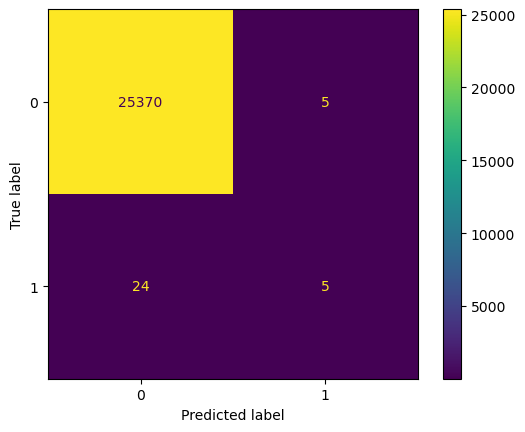

In [14]:
%matplotlib inline

# Gerando a matriz de confusão.
cm = confusion_matrix(y_test, y_pred)

# Plotando a matriz de confusão.
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [15]:
# Calculando a probabilidade de fraude.
y_prob_pred = lr.predict_proba(X_test)[::,1]

# Calculando a curva ROC.
fpr, tpr, _ = metrics.roc_curve(y_test,  y_prob_pred)

# Calculando a área sob a curva ROC.
auc = metrics.roc_auc_score(y_test, y_prob_pred)

# Plotando a curva ROC.
plt.rcParams['figure.figsize'] = (10, 8)
plt.plot(fpr,tpr,label="LR, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.legend(loc=4)

Ao analisar as métricas e o gráfico, pode-se notar que a acurácia do modelo é alta, porém as demais métricas estão muito baixas. Sendo assim, balanceamos os dados conforme abaixo para realizar predição novamente.

### Balanceamento - Oversampling

In [16]:
# Instanciando o SMOTE.
smote = SMOTE(random_state=SEED)

# Divindo os dados em features e target.
X = dados.drop(columns=['fraude'], axis=1)
y = dados['fraude']

# Aplicando o SMOTE aos dados de treino.
X_train_smote, y_train_smote = smote.fit_resample(X, y)

In [17]:
# Concatenando os dados balanceados ao dataframe original.
dados_balanceados = pd.concat([y_train_smote, X_train_smote], axis=1)
dados_balanceados

fraude  tempo          valor  saldo_inicial_c1  novo_saldo_c1  \
0            0      1    9839.640000     170136.000000      160296.36   
1            0      1    1864.280000      21249.000000       19384.72   
2            1      1     181.000000        181.000000           0.00   
3            1      1     181.000000        181.000000           0.00   
4            0      1   11668.140000      41554.000000       29885.86   
...        ...    ...            ...               ...            ...   
202989       1      5   17608.962863      17608.962863           0.00   
202990       1      7   12116.291013      12116.291013           0.00   
202991       1      1  231612.880715     231612.880715           0.00   
202992       1      9  547325.144758     547325.144758           0.00   
202993       1      4  159298.594420     159298.594420           0.00   

        saldo_inicial_c2  novo_saldo_c2  tipo_CASH_IN  tipo_CASH_OUT  \
0               0.000000       0.000000         False          False   
1               0.000000       0.000000         False          False   
2               0.000000       0.000000         False          False   
3           21182.000000       0.000000         False           True   
4               0.000000       0.000000         False          False   
...                  ...            ...           ...            ...   
202989          0.000000       0.000000         False          False   
202990          0.000000       0.000000         False          False   
202991       1945.589357    9370.603471         False           True   
202992          0.000000       0.000000         False          False   
202993          0.000000       0.000000         False          False   

        tipo_DEBIT  tipo_PAYMENT  tipo_TRANSFER  
0            False          True          False  
1            False          True          False  
2            False         False           True  
3            False         False          False  
4            False          True          False  
...            ...           ...            ...  
202989       False         False           True  
202990       False         False           True  
202991       False         False           True  
202992       False         False           True  
202993       False         False           True  

[202994 rows x 12 columns]

In [18]:
# Verificando o balanceamento das classes.
dados_balanceados['fraude'].value_counts()

fraude
0    101497
1    101497
Name: count, dtype: int64

### Realizando predição após balanceamento

In [19]:
# Features
X = dados_balanceados.drop(columns=['fraude'], axis=1)

# Target
y = dados_balanceados['fraude']

# Separando dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=SEED)

# Treinando o modelo.
lr.fit(X_train, y_train)

# Fazendo previsões.
y_pred = lr.predict(X_test)

# Imprimindo as métricas.
print(f'Acurácia: {metrics.accuracy_score(y_test, y_pred)}')
print(f'Precisão: {metrics.precision_score(y_test, y_pred)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
print(f'F1: {metrics.f1_score(y_test, y_pred)}')

Acurácia: 0.942067823996532
Precisão: 0.9257572306991574
Recall: 0.9612201466067628
F1: 0.9431554524361948


A acurácia baixou para 0.94, porém as demais métricas teve um aumento significativo: A precisão foi para 0.92, o Recall (sensibilidade) foi para 0.96 e o f1_score foi para 0.94. Pode-se concluir que a acurácia está muito boa, pois o f1_score está alto.

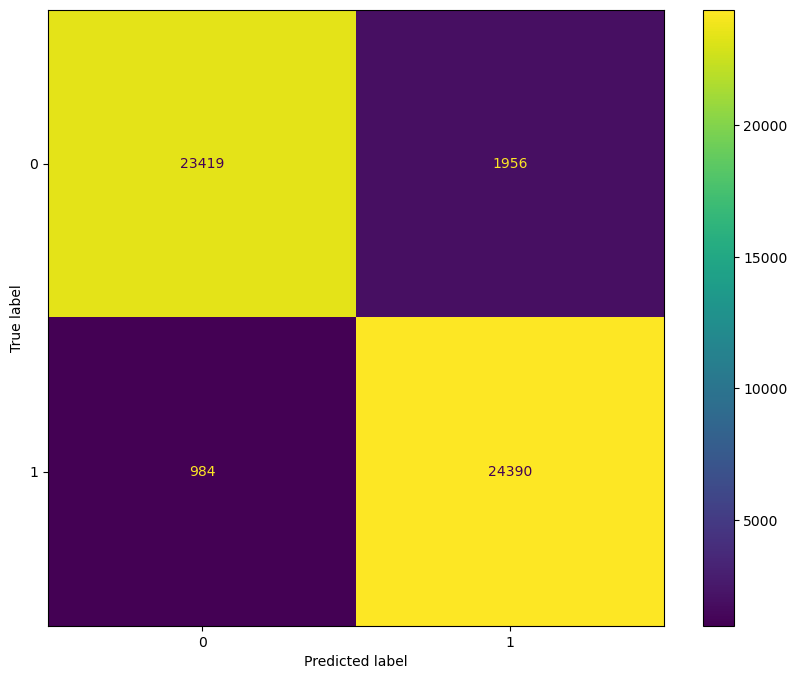

In [20]:
%matplotlib inline

# Gerando a matriz de confusão.
cm = confusion_matrix(y_test, y_pred)

# Plotando a matriz de confusão.
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Quanto a matriz de confusão, podemos notar que acertou mais casos de fraude que casos de não-fraude e está balanceada.

In [21]:
# Calculando a probabilidade de fraude.
y_prob_pred = lr.predict_proba(X_test)[::,1]

# Calculando a curva ROC.
fpr, tpr, _ = metrics.roc_curve(y_test,  y_prob_pred)

# Calculando a área sob a curva ROC.
auc = metrics.roc_auc_score(y_test, y_prob_pred)

# Plotando a curva ROC.
plt.rcParams['figure.figsize'] = (10, 8)
plt.plot(fpr,tpr,label="LR, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.legend(loc=4)

Na nova Curva Roc, a subida é bem mais rápida e a linearidade muito maior. A Curva AUC também melhorou, de 0.92 foi para 0.963 e está muito mais suave e com estabilização mais rápida. 

## Formulando hipóteses

In [22]:
ProfileReport(dados_balanceados)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Hipóteses**

- tipo_PAYMENT é o que as pessoas utilizam como padrão e a fraude ocorre por meio do tipo_TRANSFER.
- O cliente pode fazer seus pagamentos durante um período do dia, como por exemplo durante  amanhã, e a fraude ocorre durante um período diferente, como a madrugada.
- O cliente paga suas contas no começo do mês e houve uma movimentação no final do mês, sendo uma fraude.



## Modelo - Decision Tree Classifier

In [23]:
# Instanciando o modelo.
dt = DecisionTreeClassifier(max_depth=5, random_state=SEED)

# Treinando o modelo.
dt.fit(X_train, y_train)

# Fazendo previsões.
y_pred_dt = dt.predict(X_test)

# Imprimindo as métricas.
print(f'Acurácia: {metrics.accuracy_score(y_test, y_pred_dt)}')
print(f'Precisão: {metrics.precision_score(y_test, y_pred_dt)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred_dt)}')
print(f'F1: {metrics.f1_score(y_test, y_pred_dt)}')

Acurácia: 0.9590730851839445
Precisão: 0.936780531703476
Recall: 0.9845905257350044
F1: 0.9600906942336146


Ao analisar as métricas, podemos notar que todas as métricas são maiores em relação ao modelo de regressão logística.

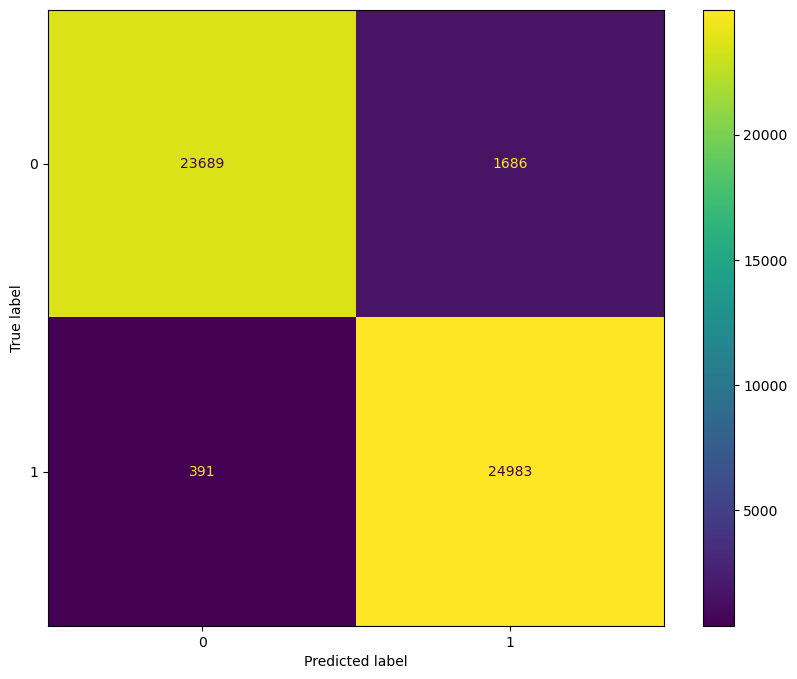

In [24]:
%matplotlib inline

# Gerando a matriz de confusão.
cm = confusion_matrix(y_test, y_pred_dt)

# Plotando a matriz de confusão.
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Podemos notar também que o modelo está prevendo maior quantidade de dados corretamente.

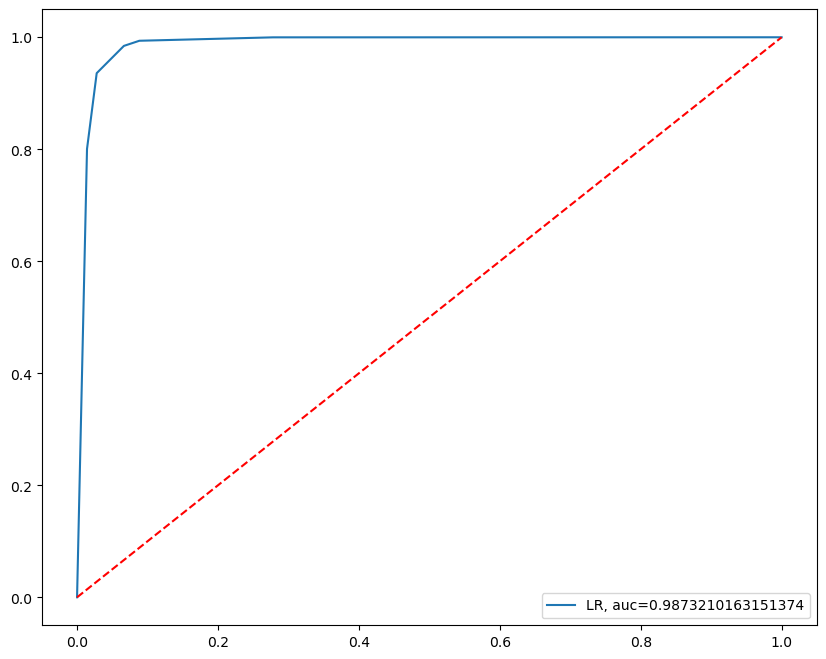

In [25]:
# Calculando a probabilidade de fraude.
y_prob_pred = dt.predict_proba(X_test)[::,1]

# Calculando a curva ROC.
fpr, tpr, _ = metrics.roc_curve(y_test,  y_prob_pred)

# Calculando a área sob a curva ROC.
auc = metrics.roc_auc_score(y_test, y_prob_pred)

# Plotando a curva ROC.
plt.rcParams['figure.figsize'] = (10, 8)
plt.plot(fpr,tpr,label="LR, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.legend(loc=4)

Por fim, ao analisar o gráfico, é perceptível que está subindo de forma muito mais linear, ou seja, está bem mais suave que o modelo anterior.
Sendo assim, podemos concluir que este modelo está melhor em relação ao anterior.

## Modelo - Random Forest Classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Instanciando o modelo.
rf = RandomForestClassifier(max_depth=5, random_state=SEED, n_estimators=100)

# Treinando o modelo.
rf.fit(X_train, y_train)

# Fazendo previsões.
y_pred_rf = rf.predict(X_test)

# Imprimindo as métricas.
print(f'Acurácia: {metrics.accuracy_score(y_test, y_pred_rf)}')
print(f'Precisão: {metrics.precision_score(y_test, y_pred_rf)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred_rf)}')
print(f'F1: {metrics.f1_score(y_test, y_pred_rf)}')

Acurácia: 0.9695954600090643
Precisão: 0.9759916909679224
Recall: 0.9628753842515961
F1: 0.9693891721387903


Podemos observar que as métricas do modelo são bem altas.

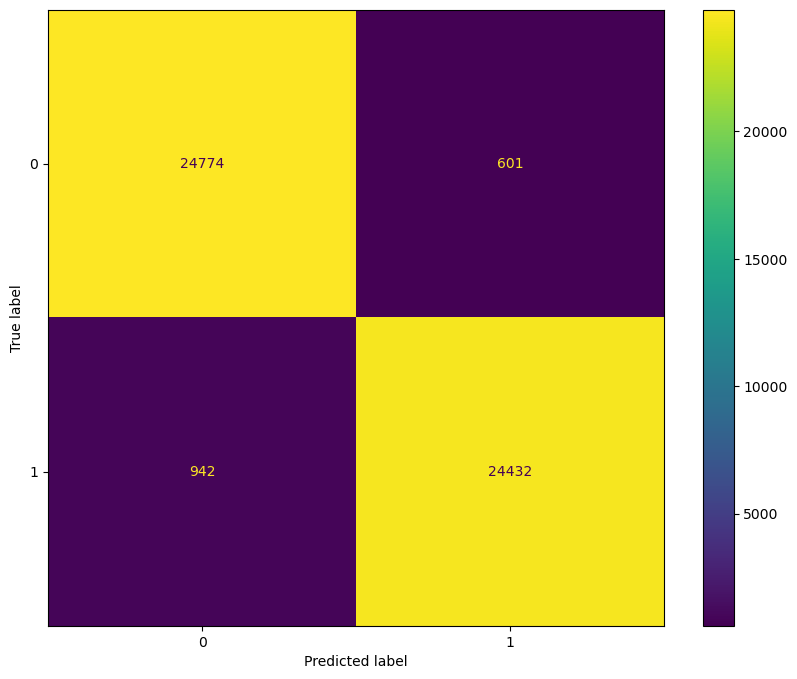

In [27]:
%matplotlib inline

# Gerando a matriz de confusão.
cm = confusion_matrix(y_test, y_pred_rf)

# Plotando a matriz de confusão.
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Porém, ao analisar a matriz de confusão do Random Forest, podemos notar que os resultados não foram tão bons em relação aos modelos anteriores.

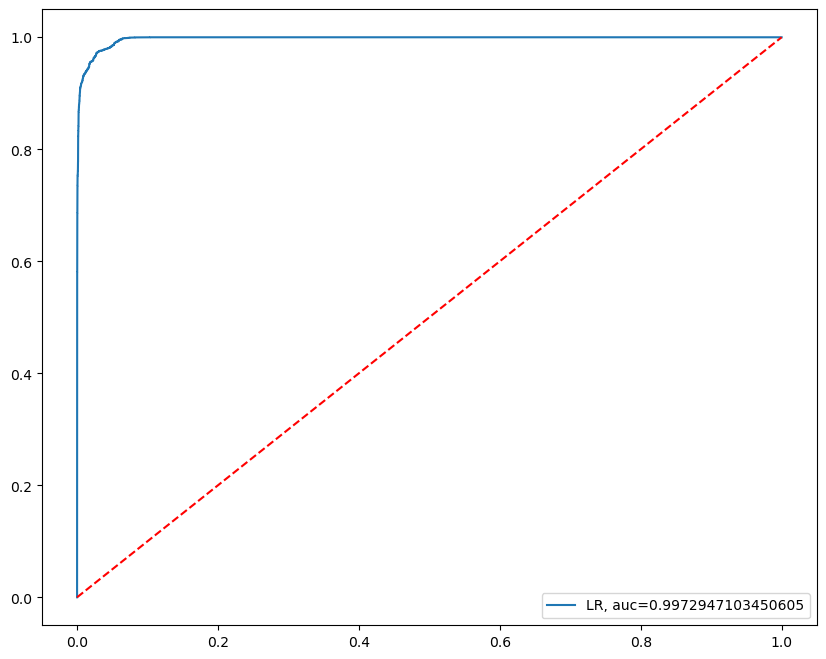

In [28]:
# Calculando a probabilidade de fraude.
y_prob_pred = rf.predict_proba(X_test)[::,1]

# Calculando a curva ROC.
fpr, tpr, _ = metrics.roc_curve(y_test,  y_prob_pred)

# Calculando a área sob a curva ROC.
auc = metrics.roc_auc_score(y_test, y_prob_pred)

# Plotando a curva ROC.
plt.rcParams['figure.figsize'] = (10, 8)
plt.plot(fpr,tpr,label="LR, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.legend(loc=4)

O resultado é 0.997, ela está melhor que a anterior. Podemos notar fez uma curva suave próxima ao ponto 1 no eixo y, diferente do modelo anterior que se assemelha a uma reta.

## Análise de Métricas

In [29]:
classifiers = [
    LogisticRegression(max_iter=1000, random_state=SEED),
    DecisionTreeClassifier(max_depth=5, random_state=SEED),
    RandomForestClassifier(max_depth=5, random_state=SEED, n_estimators=100)
]

------------------------------
LogisticRegression
**********   Resultados   **********
Acurácia: 0.942067823996532
Precisão: 0.9257572306991574
Recall: 0.9612201466067628
F1: 0.9431554524361948
------------------------------
DecisionTreeClassifier
**********   Resultados   **********
Acurácia: 0.9590730851839445
Precisão: 0.936780531703476
Recall: 0.9845905257350044
F1: 0.9600906942336146
------------------------------
RandomForestClassifier
**********   Resultados   **********
Acurácia: 0.9695954600090643
Precisão: 0.9759916909679224
Recall: 0.9628753842515961
F1: 0.9693891721387903


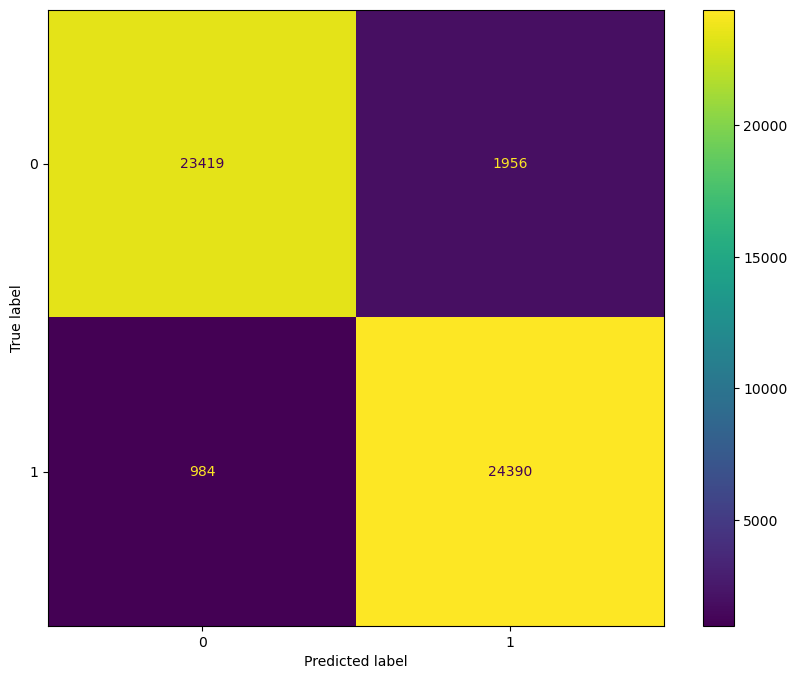

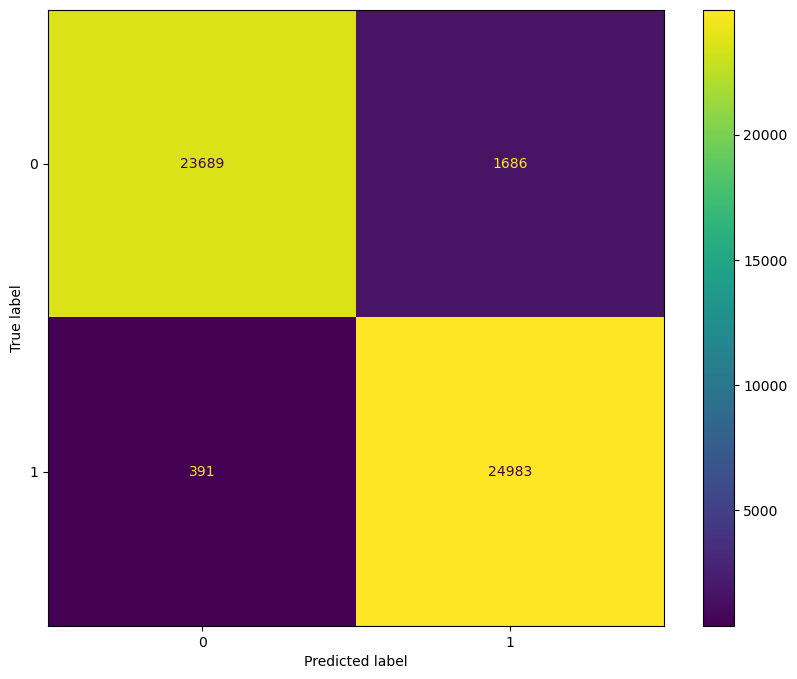

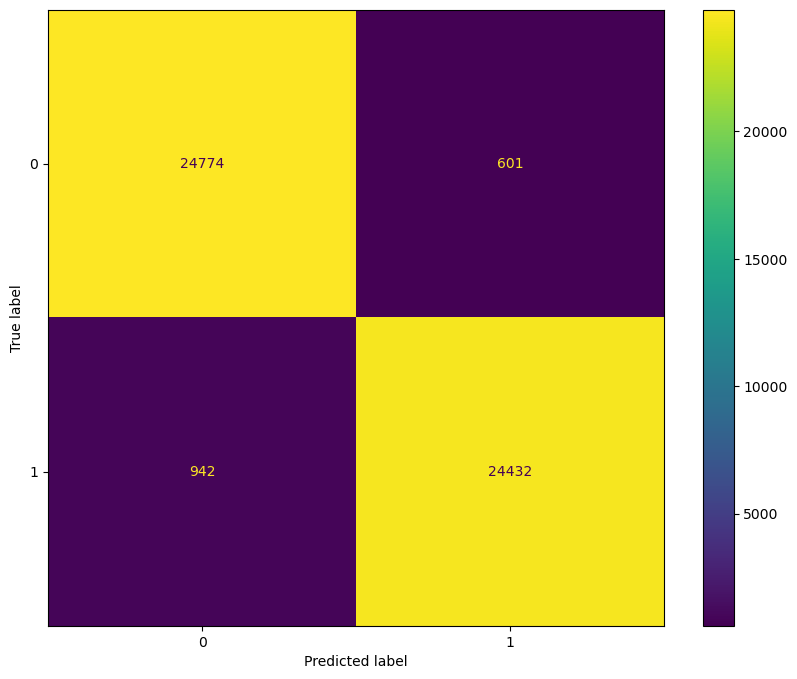

In [30]:
# Loop para treinar os modelos e imprimir as métricas.
for clf in classifiers:

    # Treinando o modelo.
    clf.fit(X_train, y_train)

    # Imprimindo o nome do modelo.
    nome = clf.__class__.__name__
    
    # Imprimindo as métricas.
    print('-'*30)
    print(nome)
    print('**********   Resultados   **********')
    y_pred = clf.predict(X_test)
    print(f'Acurácia: {metrics.accuracy_score(y_test, y_pred)}')
    print(f'Precisão: {metrics.precision_score(y_test, y_pred)}')
    print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
    print(f'F1: {metrics.f1_score(y_test, y_pred)}')

    # Gerando a matriz de confusão.
    cm = confusion_matrix(y_test, y_pred)

    # Plotando a matriz de confusão.
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

O Random Forest apresenta resultados superiores em acurácia, exceto no Recall, onde a Decision Tree é ligeiramente melhor. Embora a Decision Tree tenha um Recall superior, isso resulta em mais falsos negativos, indicando uma falha de segurança significativa.

Apesar da maior capacidade da Decision Tree em identificar fraudes, isso leva a mais notificações aos clientes e possíveis cancelamentos de transações legítimas, gerando insatisfação. 

Portanto, decidimos que o Random Forest é mais equilibrado e sugere a escolha desse modelo para melhorias, visando alcançar um Recall tão bom quanto o da Decision Tree, mantendo um equilíbrio entre detecção de fraudes e satisfação do cliente.

## Melhorando o modelo

In [31]:
# Definindo os hiperparâmetros.
n_estimators = np.arange(20, 200, step=20)
criterion = ['gini', 'entropy']
max_features = ['sqrt', 'log2']
max_depth = list(np.arange(2, 10, step=1))
min_samples_split = np.arange(2, 10, step=2)
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [32]:
# Criando o grid para o RandomizedSearchCV.
param_grid = {
    'n_estimators': n_estimators,
    'criterion': criterion,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

In [33]:
# Definindo o SEED.
SEED = 70

# Instanciando o modelo.
rf = RandomForestClassifier(random_state=SEED)

# Instanciando o RandomizedSearchCV.
random_cv = RandomizedSearchCV(estimator=rf,
                               param_distributions=param_grid,
                               cv=3,
                               n_iter=5,
                               scoring='recall',
                               n_jobs=-1,
                               random_state=SEED,
                               error_score='raise')

In [34]:
rcv = random_cv.fit(X, y)

pd.DataFrame(rcv.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      93.236027      1.748666         2.351583        0.102929   
1      40.624859      0.486915         1.312167        0.034486   
2      30.680277      1.805543         1.336499        0.027697   
3      85.270394      1.488584         1.901446        0.141810   
4      58.143721      7.144820         1.117798        0.253598   

  param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                180                       6                      4   
1                120                       4                      2   
2                 80                       4                      4   
3                180                       2                      2   
4                100                       8                      4   

  param_max_features param_max_depth param_criterion param_bootstrap  \
0               log2               5            gini           False   
1               sqrt               2         entropy           False   
2               log2               3            gini           False   
3               sqrt               8            gini            True   
4               log2               9            gini           False   

                                              params  split0_test_score  \
0  {'n_estimators': 180, 'min_samples_split': 6, ...           0.972984   
1  {'n_estimators': 120, 'min_samples_split': 4, ...           0.914223   
2  {'n_estimators': 80, 'min_samples_split': 4, '...           0.958087   
3  {'n_estimators': 180, 'min_samples_split': 2, ...           0.981556   
4  {'n_estimators': 100, 'min_samples_split': 8, ...           0.991340   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.995655           0.963082         0.977241        0.013634   
1           0.931398           0.930155         0.925259        0.007820   
2           0.965832           0.949929         0.957949        0.006493   
3           0.999438           0.982797         0.987931        0.008153   
4           0.999645           0.991546         0.994177        0.003868   

   rank_test_score  
0                3  
1                5  
2                4  
3                2  
4                1

In [35]:
# Imprimindo o melhor parâmetro.
print(f'Melhor parâmetro: {rcv.best_params_}')

Melhor parâmetro: {'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 9, 'criterion': 'gini', 'bootstrap': False}


## Resultados Finais

In [36]:
# Instanciando o modelo com os melhores parâmetros.
rf_best = RandomForestClassifier(**rcv.best_params_, random_state=SEED)

# Treinando o modelo.
rf_best.fit(X_train, y_train)

# Fazendo previsões.
y_pred_rf = rf_best.predict(X_test)

# Imprimindo as métricas.
print(f'Acurácia: {metrics.accuracy_score(y_test, y_pred_rf)}')
print(f'Precisão: {metrics.precision_score(y_test, y_pred_rf)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred_rf)}')
print(f'F1: {metrics.f1_score(y_test, y_pred_rf)}')

Acurácia: 0.9919998423614258
Precisão: 0.9902992694996465
Recall: 0.9937337432017025
F1: 0.992013533716264


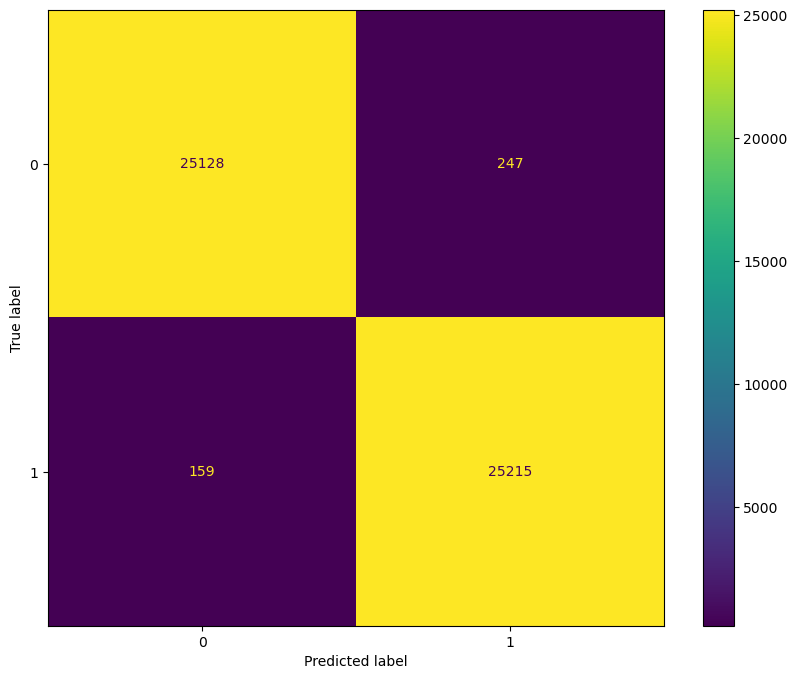

In [37]:
# Gerando a matriz de confusão.
cm = confusion_matrix(y_test, y_pred_rf)

# Plotando a matriz de confusão.
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Podemos observar que o modelo está prevendo mais quantidade de dados corretamente após os reajustes. Diminuímos os falsos positivos para 159, ou seja, fraudes despercebidas. Quanto os falsos negativos para 247, ou seja, a quantidade de transferências que não são fraudes. 

## Conclusão

Algumas soluções para cada hipótese:

- O cliente tem um certo padrão de movimentação do dinheiro, em horário comercial, e a fraude ocorreu fora deste horário, como por exemplo durante a madrugada.

- Ainda em relação ao tempo, o cliente pode fazer suas principais movimentações em um período inicial do mês e a fraude foi vista em um dia não habitual.

- Fazer um CAPTCHA para aumentar a segutança em horários não convencionais.

- O cilente utiliza como padrão o pagameento em dinheiro, seja por PIX ou retirada, e a fraude pode ocorrer por uma pagamento por transferência.

- Solicitar uma verificação de informação adicional do banco, como uma pergunta de segurança, para movimentações de transferência.